In [8]:
import numpy as np
import cv2
# import skimage
import matplotlib.pyplot as plt
import src.cp_hw2
import os

In [ ]:
plt.imshow(np.tile(np.linspace(0, 1, 255*16), (255*12,1)), cmap='gray')
plt.savefig('ramp1.jpeg',dpi=2400)

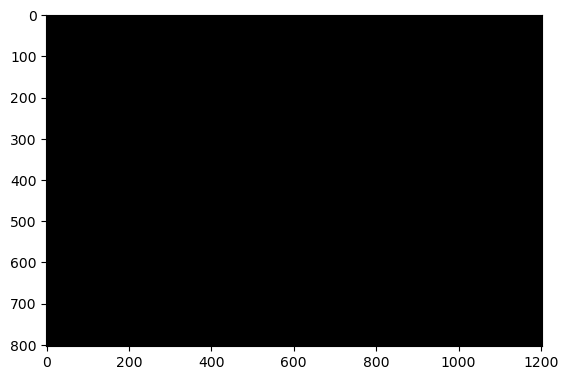

In [3]:
# load dark images
# using shutter speed 1/5
# dark_img_root = '/home/aramesh/gphoto-burst-dark-shutter1by5/'
dark_img_root = '/home/aramesh/Desktop/15-663 Computational Photography/assgn2/data-dump/gphoto-burst-dark-shutter1by10-myroom-iso100/'
dark_img_tiffs = os.listdir(dark_img_root)
dark_img_tiffs = [f for f in dark_img_tiffs if 'tiff' in f]
dark_img = cv2.imread(dark_img_root+dark_img_tiffs[0], -1)
dark_img = dark_img[...,::-1]
dark_img = dark_img[::5,::5]
dark_frame_mean = dark_img.copy()
for i in range(1,len(dark_img_tiffs)) : 
    img = cv2.imread(dark_img_root+dark_img_tiffs[i], -1)
    img = img[...,::-1]
    img = img[::5,::5]
    dark_frame_mean += img    
    
dark_frame_mean = dark_frame_mean/len(dark_img_tiffs)
plt.imshow(dark_frame_mean/ (2**16 - 1)) # this needs to be normalized as its uint16
np.save('dark-frame-mean-myroom-shutter1by10-iso100-skip5', dark_frame_mean)

In [10]:
# load and prep ramp images
ramp_img_root = '/home/aramesh/Desktop/15-663 Computational Photography/assgn2/data-dump/gphoto-burst-ramp-shutter1by10-myroom-iso100/'
# dark_frame_mean = np.load('dark-frame-mean.npy') # if already saved
dark_frame_mean = np.load('dark-frame-mean-myroom-shutter1by10-iso100-skip5.npy')
ramp_img_tiffs_names = os.listdir(ramp_img_root)
ramp_img_tiffs_names = [f for f in ramp_img_tiffs_names if 'tiff' in f]
ramp_img_tiffs = []
for i in range(len(ramp_img_tiffs_names)) : 
    ramp_img_tiff = cv2.imread(ramp_img_root+ramp_img_tiffs_names[i], -1)
    ramp_img_tiff = ramp_img_tiff[...,::-1]
    ramp_img_tiff = ramp_img_tiff[::5,::5]
    ramp_img_tiff_meansub = ramp_img_tiff - dark_frame_mean
    ramp_img_tiffs.append(ramp_img_tiff_meansub)
ramp_img_tiffs = np.array(ramp_img_tiffs)

In [11]:
ramp_img_tiffs.shape

(50, 804, 1204, 3)

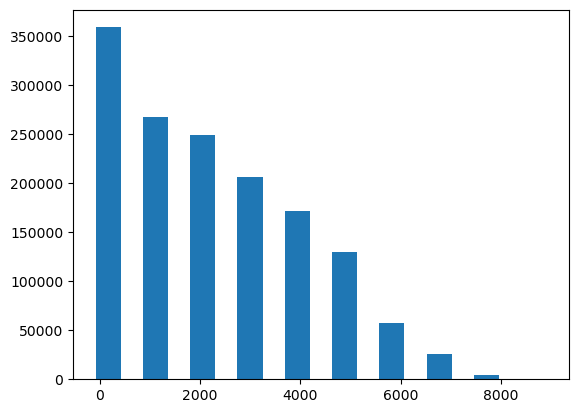

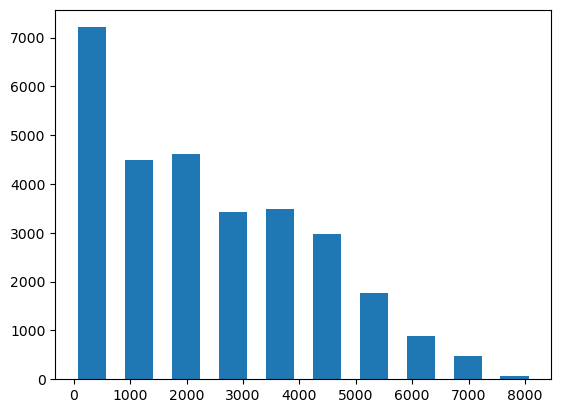

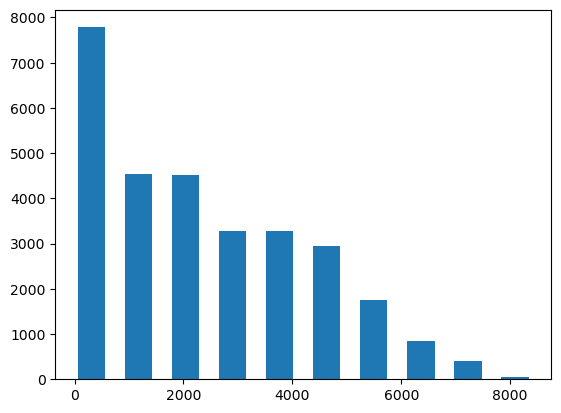

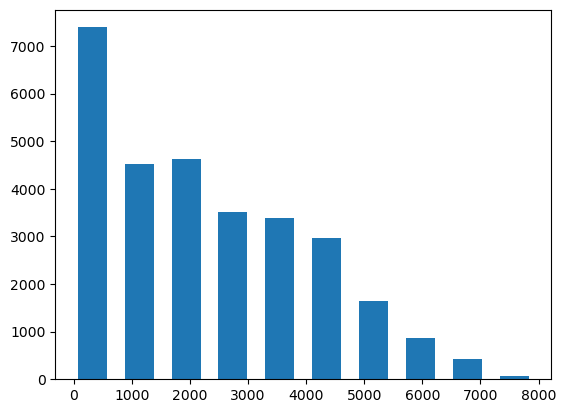

In [14]:
# Computing histogram
hist_subsample = []
for im in ramp_img_tiffs :
    hist_subsample.append(im[::10,::10])
hist_subsample = np.array(hist_subsample)
H, bins = np.histogram(hist_subsample)
plt.bar(bins[:-1], H, width=500)
plt.show()
H0, bins0 = np.histogram(hist_subsample[0])
plt.bar(bins0[:-1], H0, width=500)
plt.show()
H5, bins5 = np.histogram(hist_subsample[5])
plt.bar(bins5[:-1], H5, width=500)
plt.show()
H10, bins10 = np.histogram(hist_subsample[10])
plt.bar(bins10[:-1], H10, width=500)
plt.show()

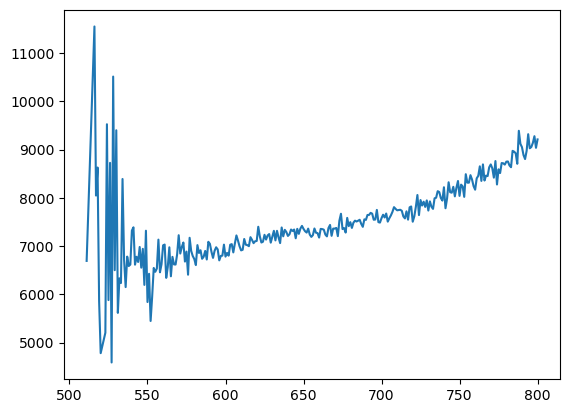

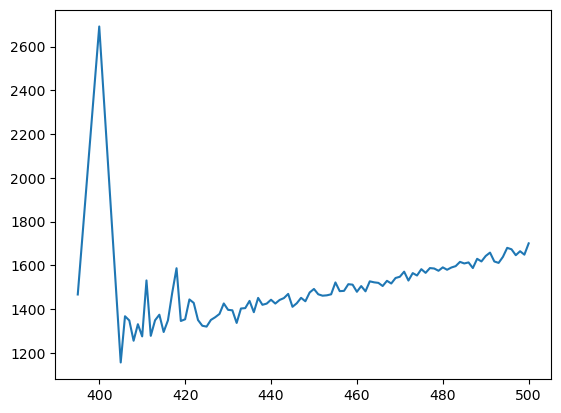

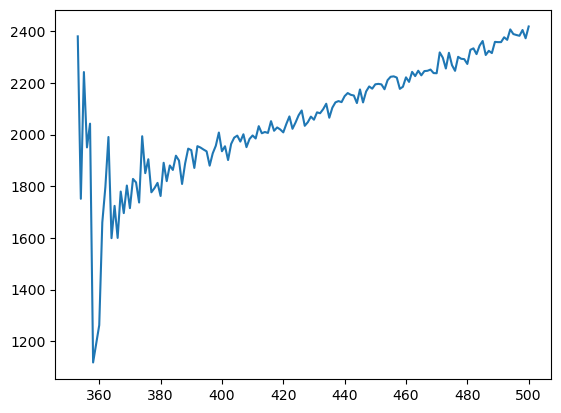

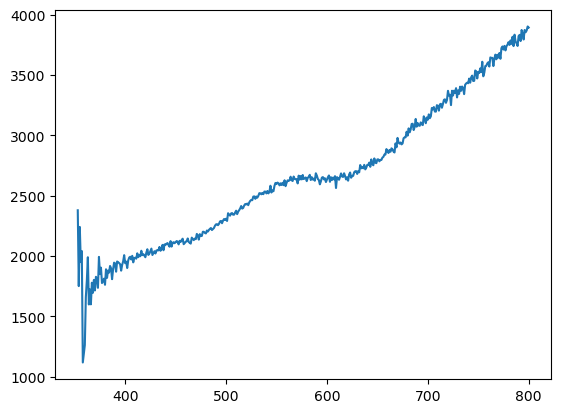

In [30]:
# Computing pixel-wise mean 

# Normalizing, then multiplying it into 255 to get fewer buckets and lesser variance

ramp_img_tiff_normalized = ramp_img_tiffs 

pixel_wise_mean = ramp_img_tiff_normalized.mean(0)

# Computing pixel-wise variance
pixel_wise_var = (ramp_img_tiff_normalized[0] - pixel_wise_mean) ** 2
for i in range(1,len(ramp_img_tiffs)) : 
    pixel_wise_var += ((ramp_img_tiff_normalized[i] - pixel_wise_mean)**2)

pixel_wise_var = pixel_wise_var / (len(ramp_img_tiffs)-1) # no numerical stability issues
# pixel_wise_var = ramp_img_tiff_normalized.var(0)
pixel_wise_mean = pixel_wise_mean.round().astype('uint16') 

cutoff = 20000 # for gain
# cutoff = 800 # for addvar
# channelwise_cutoffs = [800,500,500] # for addvar
# Computing avg pixel-wise variance for each unique mean value, channel-wise
pw_mean_uniq_list = []
pw_var_mean_list = []
for c in range(3) :
    cw_mean_uniq_list = []
    cw_var_mean_list = []
    for uniq in np.unique(pixel_wise_mean[:,:,c]) : 
        if uniq > cutoff : break
        if uniq > channelwise_cutoffs[c] : break #comment when we want to measure gain
#         if uniq > 2500 : break
#         if c == 0 : 
#             if uniq > 15 : break # excluding all mean values above threshold, which was picked to give non negative intercept
#         elif c == 1 : 
#             if uniq > 11 : break
#         else :
#             if uniq > 13 : break
        rows, cols = np.where(pixel_wise_mean[:,:,c] == uniq)
        pw_var_mean = pixel_wise_var[rows,cols,c].mean()
        cw_mean_uniq_list.append(uniq)
        cw_var_mean_list.append(pw_var_mean)
        
    pw_mean_uniq_list.append(cw_mean_uniq_list)
    pw_var_mean_list.append(cw_var_mean_list)
pw_mean_uniq_list[0],pw_mean_uniq_list[1],pw_mean_uniq_list[2] = np.array(pw_mean_uniq_list[0]), \
                            np.array(pw_mean_uniq_list[1]), np.array(pw_mean_uniq_list[2])
pw_var_mean_list[0],pw_var_mean_list[1],pw_var_mean_list[2] = np.array(pw_var_mean_list[0]), \
                            np.array(pw_var_mean_list[1]), np.array(pw_var_mean_list[2])
plt.plot(pw_mean_uniq_list[0], pw_var_mean_list[0])
plt.show()
plt.plot(pw_mean_uniq_list[1], pw_var_mean_list[1])
plt.show()
plt.plot(pw_mean_uniq_list[2], pw_var_mean_list[2])
plt.show()

# Computing avg pixel-wise variance for each unique mean value
pw_var_mean_list_all_channels = []
pw_mean_uniq_list_all_channels = []
for uniq in np.unique(pixel_wise_mean) : 
    if uniq > cutoff : break
    rows, cols, channels = np.where(pixel_wise_mean == uniq)
    pw_var_mean = pixel_wise_var[rows,cols,c].mean()
    pw_mean_uniq_list_all_channels.append(uniq)
    pw_var_mean_list_all_channels.append(pw_var_mean)

pw_var_mean_list_all_channels, pw_mean_uniq_list_all_channels = np.array(pw_var_mean_list_all_channels), np.array(pw_mean_uniq_list_all_channels)
plt.plot(pw_mean_uniq_list_all_channels,pw_var_mean_list_all_channels)
plt.show()

gain and add_var need to be scaled up as this mean img brought down to 0-255
red gain = 7.3560641821540855 add_var = 2671.274681360358
green gain = 2.6448211695040906 add_var = 301.8739903182136
blue gain = 4.5009159905476785 add_var = 147.45178412841946
mean gain = 4.833933780735285 add_var = 1040.2001519356638
all channel gain = 4.416838503147344 add_var = 109.89622638828904


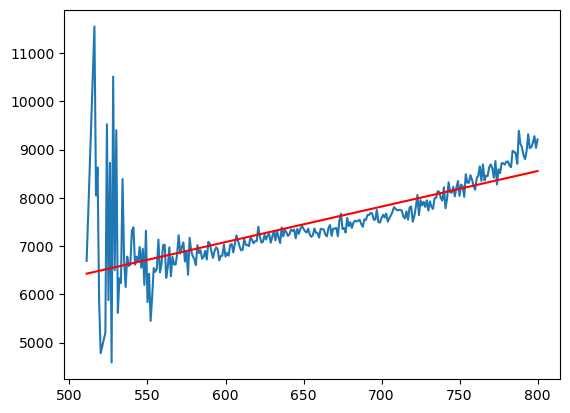

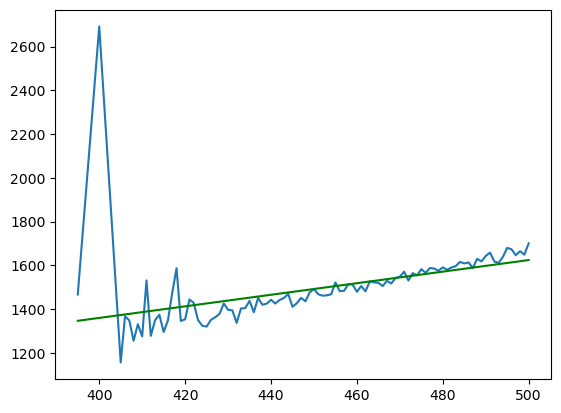

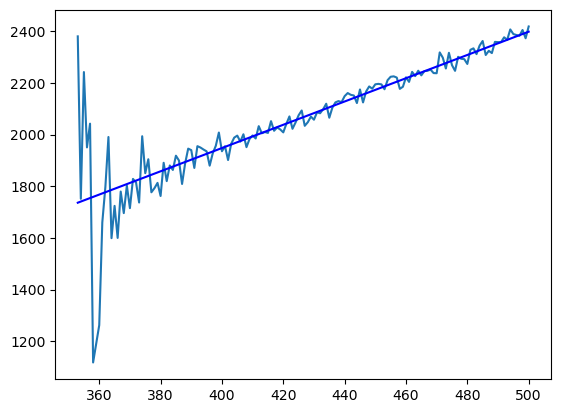

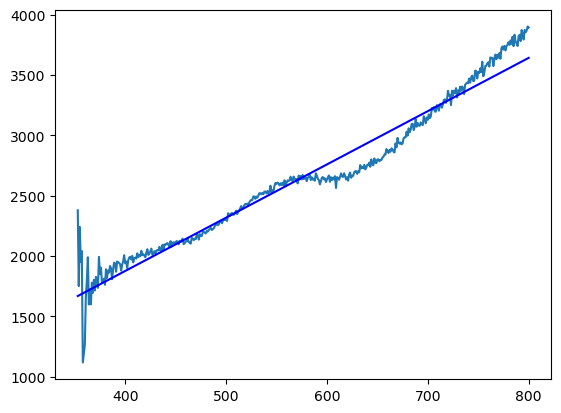

In [31]:
# Fitting a line through above plots
r_m, r_c = np.polyfit(pw_mean_uniq_list[0], pw_var_mean_list[0],1)
g_m, g_c = np.polyfit(pw_mean_uniq_list[1], pw_var_mean_list[1],1)
b_m, b_c = np.polyfit(pw_mean_uniq_list[2], pw_var_mean_list[2],1)
a_m, a_c = np.polyfit(pw_mean_uniq_list_all_channels,pw_var_mean_list_all_channels,1)

print('gain and add_var need to be scaled up as this mean img brought down to 0-255')
print('red gain = {} add_var = {}'.format(r_m,r_c))
print('green gain = {} add_var = {}'.format(g_m,g_c))
print('blue gain = {} add_var = {}'.format(b_m,b_c))
print('mean gain = {} add_var = {}'.format((r_m+b_m+g_m)/3,(r_c+b_c+g_c)/3))
print('all channel gain = {} add_var = {}'.format(a_m,a_c))


plt.plot(pw_mean_uniq_list[0], pw_var_mean_list[0])
plt.plot(pw_mean_uniq_list[0], pw_mean_uniq_list[0]*r_m + r_c, 'r')
plt.show()
plt.plot(pw_mean_uniq_list[1], pw_var_mean_list[1])
plt.plot(pw_mean_uniq_list[1], pw_mean_uniq_list[1]*g_m + g_c, 'g')
plt.show()
plt.plot(pw_mean_uniq_list[2], pw_var_mean_list[2])
plt.plot(pw_mean_uniq_list[2], pw_mean_uniq_list[2]*b_m + b_c, 'b-')
plt.show()
plt.plot(pw_mean_uniq_list_all_channels, pw_var_mean_list_all_channels)
plt.plot(pw_mean_uniq_list_all_channels,pw_mean_uniq_list_all_channels*a_m + a_c, 'b-')
plt.show()

# a_m = (a_m * (2 ** 16 - 1) / 255)
# a_c = (a_c * (((2 ** 16 - 1) / 255)**2))
# print('\n unnormalized all channel gain = {} \n add_var = {}'.format(a_m,a_c))

# When fitting on the entire graph, take gain from here
# red gain = 30.819668560124956 add_var = -34223.476605931835
# green gain = 22.285713443976338 add_var = -24681.715112475904
# blue gain = 21.660911647440948 add_var = -21109.0362468687
# mean gain = 24.922097883847414 add_var = -26671.409321758812
# all channel gain = 16.434812354721977 add_var = -13749.254489825458

# When fitting on smaller portions
# red gain = 7.3560641821540855 add_var = 2671.274681360358
# green gain = 2.6448211695040906 add_var = 301.8739903182136
# blue gain = 4.5009159905476785 add_var = 147.45178412841946
# mean gain = 4.833933780735285 add_var = 1040.2001519356638
# all channel gain = 4.416838503147344 add_var = 109.89622638828904

In [32]:
# values selected from our hybrid fitting
r_m, g_m, b_m, a_m = 30, 22, 21, 16
r_c, g_c, b_c, a_c = 2671, 300, 150, 100

r_m_norm, g_m_norm, b_m_norm, a_m_norm = r_m, g_m, b_m, a_m
r_c_norm = r_c / (2**16 -1)**2
g_c_norm = g_c / (2**16 -1)**2
b_c_norm = b_c / (2**16 -1)**2
a_c_norm = a_c / (2**16 -1)**2

print('gains when fitted to r, g, b, and all :', r_m_norm, g_m_norm, b_m_norm, a_m_norm)
print('intercepts when fitted to r,g,b and all :', r_c, g_c, b_c, a_c)
print('addvar when fitted to r, g, b, and all :', r_c_norm, g_c_norm, b_c_norm, a_c_norm)

gains when fitted to r, g, b, and all : 30 22 21 16
intercepts when fitted to r,g,b and all : 2671 300 150 100
addvar when fitted to r, g, b, and all : 6.219096282303523e-07 6.985132477315826e-08 3.492566238657913e-08 2.3283774924386086e-08


In [33]:
# Loading my hdr stack
# t_filler = lambda x : 2.0 ** (x-1-12)
# t = [t_filler(i) for i in range(1,19)]
t = [1/4000,1/2000,1/1000,1/500,1/250,1/125,1/60,1/30,1/15,1/8,1/4,1/2,1,2,4,8,15,30] 
dark_frame_mean = np.load('dark-frame-mean-myroom-shutter1by10-iso100-skip5.npy')
def dark_frame_sub(images_stack_tiff, dark_frame_mean, t) :
    tnc = 1/10
    images_stack_tiff_darkframe_sub = np.zeros(images_stack_tiff.shape)
    for k in range(len(images_stack_tiff)) :
        images_stack_tiff_darkframe_sub[k] = images_stack_tiff[k] - ((t[k]/tnc) * dark_frame_mean) 
    return images_stack_tiff_darkframe_sub

image_files_tiff = ['data/gphoto-exposure-stack-no-noise-reduction-myroom/exposure'+str(i)+'.tiff' for i in range(1,17)]
images_stack_tiff = []
for imf in image_files_tiff :
    img = cv2.imread(imf, -1)
    img = img[...,::-1]
    img = img[::5, ::5]
    images_stack_tiff.append(img)
images_stack_tiff = np.array(images_stack_tiff)
images_stack_tiff_darkframe_sub = dark_frame_sub(images_stack_tiff, dark_frame_mean, t) 
del images_stack_tiff
images_stack_tiff_normalized = images_stack_tiff_darkframe_sub / (2**16 - 1)
# a_m_norm = a_m / (2**16 - 1)
# a_c_norm = a_c / ((2**16 - 1)**2)
# a_m_norm = a_m
# a_c_norm = a_c

In [57]:
def linear_merging(im_s, lin_im_s, t, w_v, g, var_add, is_w_photon=True) :
    
    I_hdr_num = np.zeros(im_s[0].shape)
    I_hdr_den = np.zeros(im_s[0].shape)
    for k in range(len(im_s)) :
        w_v_imk = w_v(im_s[k], t[k], g, var_add, 0.00001, 0.92) # 0.05 and 0.92 for the other calib
#         print(w_v_imk.max(), w_v_imk.min(), w_v_imk.mean())
        I_hdr_num += (w_v_imk * lin_im_s[k] / t[k] ) 
        I_hdr_den += (w_v_imk)
#         print(w_v_imk.max(), w_v_imk.min(), w_v_imk.mean())

    
    I_hdr = I_hdr_num / I_hdr_den
    
    # where num is zero, hdr final should also be zero
    I_hdr_num_zero = np.where(I_hdr_num == 0)
    if len(I_hdr_num_zero) == 3 : 
        I_hdr_num_zero = np.vstack((np.vstack((I_hdr_num_zero[0],I_hdr_num_zero[1])), I_hdr_num_zero[2])).T
    else : 
        I_hdr_num_zero = np.vstack((I_hdr_num_zero[0],I_hdr_num_zero[1])).T
        
        
    # where num is not zero, but den is zero, all hdr final values should be max val
    I_hdr_den_zero = np.where(I_hdr_den == 0)
    if len(I_hdr_den_zero) == 3 : 
        I_hdr_den_zero = np.vstack((np.vstack((I_hdr_den_zero[0],I_hdr_den_zero[1])), I_hdr_den_zero[2])).T
    else : 
        I_hdr_den_zero = np.vstack((I_hdr_den_zero[0],I_hdr_den_zero[1])).T
    
    I_hdr_max_val = []
    
    if I_hdr_num_zero.size > 0 :
        if len(I_hdr.shape) == 3 : 
            I_hdr[I_hdr_num_zero[:,0],I_hdr_num_zero[:,1],I_hdr_num_zero[:,2]] = 0
        else : 
            I_hdr[I_hdr_num_zero[:,0],I_hdr_num_zero[:,1]] = 0
    
    if I_hdr_den_zero.size > 0 :
        for index in I_hdr_den_zero :
            if len(I_hdr.shape) == 3 : 
#                 print(I_hdr_num[index[0],index[1],index[2]])
                if I_hdr_num[index[0],index[1],index[2]] != 0 : 
                    I_hdr_max_val.append(index)
            else : 
                if I_hdr_num[index[0],index[1]] != 0 : 
                    I_hdr_max_val.append(index)
        I_hdr_max_val = np.array(I_hdr_max_val)
        if I_hdr_max_val.size > 0 :
            I_hdr_max_val = np.stack(I_hdr_max_val)
            if len(I_hdr.shape) == 3 : 
                I_hdr[I_hdr_max_val[:,0],I_hdr_max_val[:,1],I_hdr_max_val[:,2]] = np.nanmax(I_hdr)
            else : 
                I_hdr[I_hdr_max_val[:,0],I_hdr_max_val[:,1]] = np.nanmax(I_hdr)
    
    return I_hdr

def linear_merging_channelwise(im_s, lin_im_s, t, w_v, r_m, g_m, b_m, r_c, g_c, b_c, is_w_photon=True) :
    
    I_hdr = np.zeros(im_s[0].shape)
    I_hdr[...,0] = linear_merging(im_s[...,0], lin_im_s[...,0], t, w_v, r_m, r_c, is_w_photon) # the var_add needs a normalization term
    I_hdr[...,1] = linear_merging(im_s[...,1], lin_im_s[...,1], t, w_v, g_m, g_c, is_w_photon) # the var_add needs a normalization term
    I_hdr[...,2] = linear_merging(im_s[...,2], lin_im_s[...,2], t, w_v, b_m, b_c, is_w_photon) # the var_add needs a normalization term

    return I_hdr


@np.vectorize
def weight_optimal(z,tk, g, var_add, Z_min=0.001, Z_max=0.995):
    if Z_min <= z <= Z_max :
        out_num = tk ** 2
        out_den = g * z + var_add
#         print(out_num / out_den)
#         if out_num / out_den < 30 : 
        return out_num / out_den
#         return 15
#         return tk
    return 0

# HDR display util functions
def linear_scaling(img_cc, scale, should_plot=False):
#     img_scaled = np.clip(skimage.color.rgb2gray(img_cc) * scale, 0, 1)
    img_scaled = np.clip(img_cc * scale, 0, 1)
    if should_plot : 
        plt.imshow(img_scaled)
        plt.title('linear scaling')
        plt.show()
    return img_scaled

# Gamma Encoding
def gamma_encoding(val) : 
    if val <= 0.0031308 : 
        return 12.92 * val
    else : 
        return (1+0.055) * np.power(val, 1/2.4) - 0.055

def display_hdr_image(img, scale, title='', should_plot=True) : 
    img_scaled = linear_scaling(img, scale)
    ge_f = np.vectorize(gamma_encoding)
    image_ge = ge_f(img_scaled)
    if should_plot : 
        plt.imshow(image_ge)
        plt.title(title)
        plt.show()
    return image_ge



/tmp/ipykernel_17410/362874447.py:13: RuntimeWarning: invalid value encountered in divide
  I_hdr = I_hdr_num / I_hdr_den


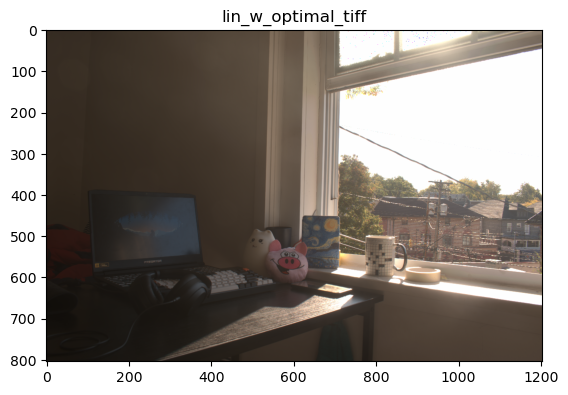

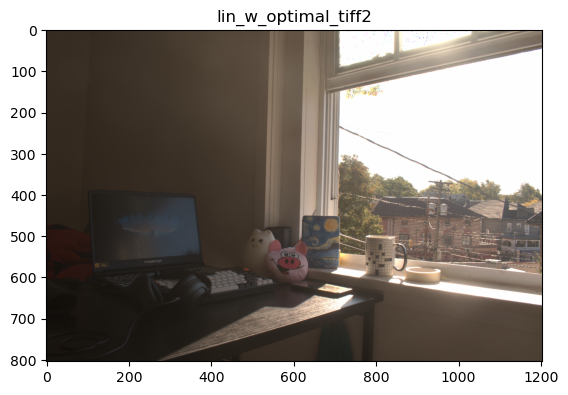

In [61]:
I_hdr_tiff_lin_merged_w_optimal = linear_merging_channelwise(images_stack_tiff_normalized, images_stack_tiff_darkframe_sub, t, weight_optimal, r_m_norm, g_m_norm, b_m_norm, r_c, g_c, b_c)
_ = display_hdr_image(I_hdr_tiff_lin_merged_w_optimal,0.0000006,'lin_w_optimal_tiff')
I_hdr_tiff_lin_merged_w_optimal2 = linear_merging(images_stack_tiff_normalized, images_stack_tiff_darkframe_sub, t, weight_optimal, a_m_norm, a_c)
_ = display_hdr_image(I_hdr_tiff_lin_merged_w_optimal2,0.0000006,'lin_w_optimal_tiff2')
# I_hdr_tiff_lin_merged_w_optimal2 = linear_merging(images_stack_tiff_normalized2, images_stack_tiff, t, weight_optimal, 30, 1000)
# _ = display_hdr_image(I_hdr_tiff_lin_merged_w_optimal2,0.000006,'lin_w_optimal_tiff2')
# I_hdr_tiff_log_merged_w_optimal = log_merging(images_stack_tiff_normalized, images_stack_tiff_darkframe_sub, t, weight_optimal, 30, 1000)
# _ = display_hdr_image(I_hdr_tiff_log_merged_w_optimal,0.1,'log_w_optimal_tiff')

src.cp_hw2.writeHDR('I_hdr_tiff_lin_merged_w_optimal-part5.HDR', I_hdr_tiff_lin_merged_w_optimal)
src.cp_hw2.writeHDR('I_hdr_tiff_lin_merged_w_optimal2-part5.HDR', I_hdr_tiff_lin_merged_w_optimal2)
# # src.cp_hw2.writeHDR('I_hdr_tiff_log_merged_w_optimal-debug.HDR', I_hdr_tiff_log_merged_w_optimal)

/tmp/ipykernel_17410/2410649774.py:48: RuntimeWarning: invalid value encountered in divide
  x = im_XYZ[...,0].copy() / im_XYZ.sum(2)
/tmp/ipykernel_17410/2410649774.py:49: RuntimeWarning: invalid value encountered in divide
  y = im_XYZ[...,1].copy() / im_XYZ.sum(2)


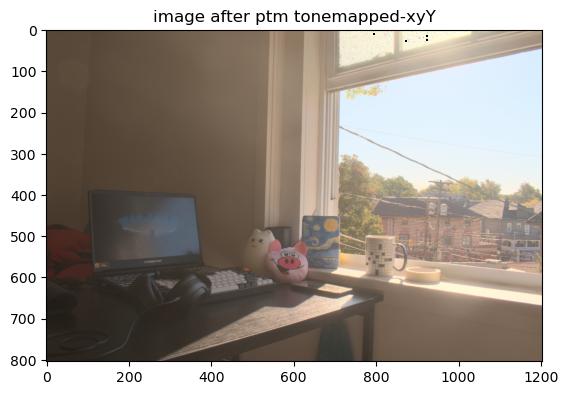

In [60]:
im_hdr_selected = I_hdr_tiff_lin_merged_w_optimal2.copy()
# im_hdr_selected = src.cp_hw2.readHDR('I_hdr_tiff_lin_merged_w_optimal-debug.HDR')
# Photographic ToneMapping

# kinda sus, make sure its right
def calc_geometric_mean_log(im) : 
    
    if im.min() < 0 : 
        # clipping out negative values and raising them to be over 0
        g_mean = np.exp(np.log(im - (1.00000001) * im.min()).mean()) 
    else : 
        # else 
        g_mean = np.exp(np.log(im + 1e5).mean()) 
    
    return g_mean

def calc_geometric_mean(im) : 
    pass

def place_key(g_mean, im, K) : 
    im_keyed= K * (im) / g_mean
    return im_keyed

def set_white(im_keyed, B) : 
    im_white = B * np.max(im_keyed)
    return im_white

# Note : don't really understand what the difference 
# would be upon applying tonemapping for the 3 channels separately
# in the case mentioned in the hints. That would be same as this right?
# unless we are setting different keys and burnouts
def complete_photographic_tonemap(im, K, B) :
    
    g_mean = calc_geometric_mean_log(im)
    im_keyed = place_key(g_mean, im, K)
    im_white = set_white(im_keyed, B)
    
    im_tonemapped_num = im_keyed * (1 + im_keyed / (im_white**2))
    im_tonemapped_den = 1 + im_keyed
    
    im_tonemapped = im_tonemapped_num / im_tonemapped_den
    
    return im_tonemapped

def complete_photographic_tonemap_throughxyY(im, K, B) :
    
    im_XYZ = src.cp_hw2.lRGB2XYZ(im)
    x = im_XYZ[...,0].copy() / im_XYZ.sum(2) 
    y = im_XYZ[...,1].copy() / im_XYZ.sum(2)
    Y = im_XYZ[...,1].copy()
    
    Y_tonemapped = complete_photographic_tonemap(Y, K, B)
    
    X = (x * Y_tonemapped) / y
    Y = Y_tonemapped
    Z = (1 - x - y) * Y_tonemapped / y
    
    im_XYZ_tonemapped = np.concatenate((np.stack((X,Y),-1),np.expand_dims(Z,-1)),-1)   
    im_RGB_tonemapped = src.cp_hw2.XYZ2lRGB(im_XYZ_tonemapped)
    
    return im_RGB_tonemapped   

# im_hdr_selected_cc_wb_ptm = complete_photographic_tonemap(im_hdr_selected, K=0.36, B=0.95)
# im_hdr_selected_cc_wb_ptm_tonemapped = display_hdr_image(im_hdr_selected_cc_wb_ptm, 1, 'image after ptm tonemapped')
# src.cp_hw2.writeHDR('im_hdr_selected_cc_wb_ptm-debug.HDR', im_hdr_selected_cc_wb_ptm)


im_hdr_selected_cc_wb_ptm_xyY = complete_photographic_tonemap_throughxyY(im_hdr_selected, K=0.6, B=0.09)
im_hdr_selected_cc_wb_ptm_tonemapped = display_hdr_image(im_hdr_selected_cc_wb_ptm_xyY, 1, 'image after ptm tonemapped-xyY')
src.cp_hw2.writeHDR('im_hdr_selected_cc_wb_ptm_xyY-part5.HDR', im_hdr_selected_cc_wb_ptm_xyY)

In [40]:
# src.cp_hw2.writeHDR('im_hdr_selected_cc_wb_ptm-debug.HDR', im_hdr_selected_cc_wb_ptm)
# src.cp_hw2.writeHDR('im_hdr_selected_cc_wb_ptm_tonemapped-debug.HDR', im_hdr_selected_cc_wb_ptm_tonemapped)